In [12]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, Dropout, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model
## Plotly
import re
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import nltk
from keras.layers import Input
import json
from sklearn.feature_extraction.text import CountVectorizer
import time
from nltk.stem.wordnet import WordNetLemmatizer
from contextlib import contextmanager
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('short_data.csv')

In [9]:
data['target'] = np.where(data['target']>=.5,1,0)

In [3]:
text = data.comment_text

In [7]:
train_df, validate_df = train_test_split(data, test_size=0.2)
print('%d train comments, %d validate comments' % (len(train_df), len(validate_df)))

188069 train comments, 47018 validate comments


In [10]:
MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 250
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

In [13]:
EMBEDDINGS_PATH = 'glove.6B.100d.txt'
EMBEDDINGS_DIMENSION = 100
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.00005
NUM_EPOCHS = 10
BATCH_SIZE = 128

def train_model(train_df, validate_df, tokenizer):
    # Prepare data
    train_text = pad_text(train_df[TEXT_COLUMN], tokenizer)
    train_labels = to_categorical(train_df[TOXICITY_COLUMN])
    validate_text = pad_text(validate_df[TEXT_COLUMN], tokenizer)
    validate_labels = to_categorical(validate_df[TOXICITY_COLUMN])

    # Load embeddings
    print('loading embeddings')
    embeddings_index = {}
    with open(EMBEDDINGS_PATH) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,
                                 EMBEDDINGS_DIMENSION))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # Create model layers.
    def get_convolutional_neural_net_layers():
        """Returns (input_layer, output_layer)"""
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                    EMBEDDINGS_DIMENSION,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
        x = embedding_layer(sequence_input)
        x = Conv1D(128, 2, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 3, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 4, activation='relu', padding='same')(x)
        x = MaxPooling1D(40, padding='same')(x)
        x = Flatten()(x)
        x = Dropout(DROPOUT_RATE)(x)
        x = Dense(128, activation='relu')(x)
        preds = Dense(2, activation='softmax')(x)
        return sequence_input, preds

    # Compile model.
    print('compiling model')
    input_layer, output_layer = get_convolutional_neural_net_layers()
    model = Model(input_layer, output_layer)
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=LEARNING_RATE),
                  metrics=['acc'])

    # Train model.
    print('training model')
    model.fit(train_text,
              train_labels,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_labels),
              verbose=2)

    return model

In [14]:
model = train_model(train_df, validate_df, tokenizer)

loading embeddings
compiling model
training model
Train on 188069 samples, validate on 47018 samples
Epoch 1/10
 - 156s - loss: 0.0263 - acc: 0.9960 - val_loss: 0.0174 - val_acc: 0.9978
Epoch 2/10
 - 152s - loss: 0.0178 - acc: 0.9976 - val_loss: 0.0162 - val_acc: 0.9978
Epoch 3/10
 - 158s - loss: 0.0175 - acc: 0.9976 - val_loss: 0.0161 - val_acc: 0.9978
Epoch 4/10
 - 145s - loss: 0.0175 - acc: 0.9976 - val_loss: 0.0164 - val_acc: 0.9978
Epoch 5/10
 - 156s - loss: 0.0174 - acc: 0.9976 - val_loss: 0.0186 - val_acc: 0.9978
Epoch 6/10
 - 154s - loss: 0.0177 - acc: 0.9976 - val_loss: 0.0172 - val_acc: 0.9978
Epoch 7/10
 - 161s - loss: 0.0179 - acc: 0.9976 - val_loss: 0.0173 - val_acc: 0.9978
Epoch 8/10
 - 145s - loss: 0.0179 - acc: 0.9976 - val_loss: 0.0184 - val_acc: 0.9978
Epoch 9/10
 - 153s - loss: 0.0181 - acc: 0.9976 - val_loss: 0.0176 - val_acc: 0.9978
Epoch 10/10
 - 152s - loss: 0.0181 - acc: 0.9976 - val_loss: 0.0181 - val_acc: 0.9978


In [17]:
y_pred = model.predict(pad_text(validate_df[TEXT_COLUMN], tokenizer))

In [26]:
text_pred = y_pred[:,0]
token_pred = y_pred[:, 1]

In [27]:
text_pred = np.where(text_pred>=.5,1,0)
token_pred = np.where(token_pred>=.5,1,0)

In [28]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
        
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [34]:
validate_df.target = np.where(validate_df['target']>=.5,1,0)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
np.where(np.mean(y_pred, axis=1)>=0.5, 1,0)

array([0, 1, 1, ..., 1, 0, 1])

,LSTM-CNN
Accuracy,0.291
Precision,0.105
Recall,0.758
F1 Score,0.184


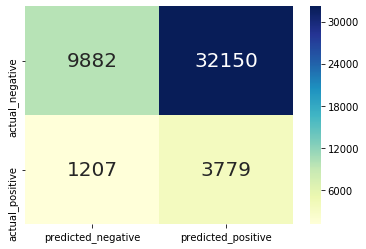

In [43]:
cm = conf_matrix(validate_df['target'], np.where(np.mean(y_pred, axis=1)>=0.5, 1,0))

# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LSTM-CNN']
results